# ML Models

## Import Libraries & Load Dataframe from AWS DB

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from math import sin, cos, sqrt, atan2, radians

import query_helper
import json


In [2]:
#start by making dict of grades/ratings
diff_grade = {'Rope': ['3rd',
  '4th',
  'Easy 5th',
  '5.0',
  '5.1',
  '5.2',
  '5.3',
  '5.4',
  '5.5',
  '5.6',
  '5.7',
  '5.7+',
  '5.8-',
  '5.8',
  '5.8+',
  '5.9-',
  '5.9',
  '5.9+',
  '5.10a',
  '5.10-',
  '5.10a/b',
  '5.10b',
  '5.10',
  '5.10b/c',
  '5.10c',
  '5.10+',
  '5.10c/d',
  '5.10d',
  '5.11a',
  '5.11-',
  '5.11a/b',
  '5.11b',
  '5.11',
  '5.11b/c',
  '5.11c',
  '5.11+',
  '5.11c/d',
  '5.11d',
  '5.12a',
  '5.12-',
  '5.12a/b',
  '5.12b',
  '5.12',
  '5.12b/c',
  '5.12c',
  '5.12+',
  '5.12c/d',
  '5.12d',
  '5.13a',
  '5.13-',
  '5.13a/b',
  '5.13b',
  '5.13',
  '5.13b/c',
  '5.13c',
  '5.13+',
  '5.13c/d',
  '5.13d',
  '5.14a',
  '5.14-',
  '5.14a/b',
  '5.14b',
  '5.14',
  '5.14b/c',
  '5.14c',
  '5.14+',
  '5.14c/d',
  '5.14d',
  '5.15a',
  '5.15-',
  '5.15a/b',
  '5.15b',
  '5.15',
  '5.15c',
  '5.15+',
  '5.15c/d',
  '5.15d'],
 'Boulder': ['V-easy',
  'V0-',
  'V0',
  'V0+',
  'V0-1',
  'V1-',
  'V1',
  'V1+',
  'V1-2',
  'V2-',
  'V2',
  'V2+',
  'V2-3',
  'V3-',
  'V3',
  'V3+',
  'V3-4',
  'V4-',
  'V4',
  'V4+',
  'V4-5',
  'V5-',
  'V5',
  'V5+',
  'V5-6',
  'V6-',
  'V6',
  'V6+',
  'V6-7',
  'V7-',
  'V7',
  'V7+',
  'V7-8',
  'V8-',
  'V8',
  'V8+',
  'V8-9',
  'V9-',
  'V9',
  'V9+',
  'V9-10',
  'V10-',
  'V10',
  'V10+',
  'V10-11',
  'V11-',
  'V11',
  'V11+',
  'V11-12',
  'V12-',
  'V12',
  'V12+',
  'V12-13',
  'V13-',
  'V13',
  'V13+',
  'V13-14',
  'V14-',
  'V14',
  'V14+',
  'V14-15',
  'V15-',
  'V15',
  'V15+',
  'V15-16',
  'V16-',
  'V16',
  'V16+',
  'V16-17',
  'V17-',
  'V17'],
 'Ice': ['WI1',
  'WI2-',
  'WI2',
  'WI2+',
  'WI2-3',
  'WI3-',
  'WI3',
  'WI3+',
  'WI3-4',
  'WI4-',
  'WI4',
  'WI4+',
  'WI4-5',
  'WI5-',
  'WI5',
  'WI5+',
  'WI5-6',
  'WI6-',
  'WI6',
  'WI6+',
  'WI6-7',
  'WI7-',
  'WI7',
  'WI7+',
  'WI7-8',
  'WI8-',
  'WI8',
  'AI1',
  'AI1-2',
  'AI2',
  'AI2-3',
  'AI3',
  'AI3-4',
  'AI4',
  'AI4-5',
  'AI5',
  'AI5-6',
  'AI6'],
 'Aid': ['C0',
  'A0',
  'C0+',
  'A0+',
  'C0-1',
  'A0-1',
  'C1-',
  'A1-',
  'C1',
  'A1',
  'C1+',
  'A1+',
  'C1-2',
  'A1-2',
  'C2-',
  'A2-',
  'C2',
  'A2',
  'C2+',
  'A2+',
  'C2-3',
  'A2-3',
  'C3-',
  'A3-',
  'C3',
  'A3',
  'C3+',
  'A3+',
  'C3-4',
  'A3-4',
  'C4-',
  'A4-',
  'C4',
  'A4',
  'C4+',
  'A4+',
  'C4-5',
  'A4-5',
  'C5-',
  'A5-',
  'C5',
  'A5',
  'C5+',
  'A5+'],
 'Mixed': ['M1',
  'M1+',
  'M1-2',
  'M2-',
  'M2',
  'M2+',
  'M2-3',
  'M3-',
  'M3',
  'M3+',
  'M3-4',
  'M4-',
  'M4',
  'M4+',
  'M4-5',
  'M5-',
  'M5',
  'M5+',
  'M5-6',
  'M6-',
  'M6',
  'M6+',
  'M6-7',
  'M7-',
  'M7',
  'M7+',
  'M7-8',
  'M8-',
  'M8',
  'M8+',
  'M8-9',
  'M9-',
  'M9',
  'M9+',
  'M9-10',
  'M10-',
  'M10',
  'M10+',
  'M10-11',
  'M11-',
  'M11',
  'M11+',
  'M12-',
  'M12',
  'M12+',
  'M13-',
  'M13',
  'M13+'],
 'Snow': ['Easy Snow', 'Mod. Snow', 'Steep Snow'],
 'Safety': [
 'PG13',
  'R',
  'X'],
 'Mountaineering': ['I', 'II', 'III', 'IV', 'V', 'VI']}

In [3]:
df = pd.read_csv('clean_data.csv')
pd.set_option('display.max_columns', 50)
df.rename(columns={'Unnamed: 0':'orig_index'}, inplace=True)
df.set_index('id', inplace=True)
df.head()

,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade
id,,,,,,,,,,,,,,,,,,,,,,,,,,
105714722,0,Central Yellow Wall,V3 R,4.4,22,0,South Dakota,Custer State Park,Sylvan Lake,Sylvan Lake Bouldering,Campground Boulder,-103.564,43.8463,https://www.mountainproject.com/route/10571472...,0,0,1,1,0,0,0,0,0,R,0,V3
105714728,1,Waves,5.8,4.6,217,2,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Shipyard Rock,-103.466,43.8865,https://www.mountainproject.com/route/10571472...,1,0,0,0,0,0,0,0,0,G,5.8,0
105714731,2,East Chimney Variation,5.7,4.1,40,2,South Dakota,Custer State Park,Cathedral Spires,Station 13,0,-103.534,43.8488,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,G,5.7,0
105714734,3,Conn Diagonal,5.7,4.9,151,3,South Dakota,Custer State Park,Sylvan Lake,Outlets,Outer Outlet,-103.568,43.8487,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,G,5.7,0
105714737,4,Bolts for Bobs,5.8,3.5,125,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Borneo,-103.469,43.8870,https://www.mountainproject.com/route/10571473...,1,0,0,0,0,0,0,0,0,G,5.8,0


### Import NLP Data and join to main df

In [4]:
# pd.options.display.max_colwidth = 100

In [5]:
# pd.set_option('display.max_colwidth', -1)

In [6]:
# df_nlp = query_helper.query_to_df('SELECT * FROM route_description;')
# df_nlp.set_index('id', inplace=True)
df_nlp = pd.read_csv('df_nlp.csv',index_col='id')
df_nlp.rename(columns={'info':'infos'}, inplace=True)
df_nlp.at[117568267,'infos'] = ''
df_nlp.head(1)

,infos
id,
105714722,The Central Yellow Wall is a classic must-do p...


In [7]:
df_full = df.join(df_nlp)
df_full.head(1)

,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
105714722,0,Central Yellow Wall,V3 R,4.4,22,0,South Dakota,Custer State Park,Sylvan Lake,Sylvan Lake Bouldering,Campground Boulder,-103.564,43.8463,https://www.mountainproject.com/route/10571472...,0,0,1,1,0,0,0,0,0,R,0,V3,The Central Yellow Wall is a classic must-do p...


## Add columns for route description types from NLP

In [8]:
key_words = ['slab', 'traverse', 'roof', 'corner', 'crack', 'face','flake', 'finger', 'fingers',
             'hand', 'hands', 'arch', 'balancy', 'balance', 'jug', 'squeeze', 'mantel', 'sustained',  
             'ramp', 'overhung', 'dihedral', 'sporty', 'heady', 'pump', 'pumpy', 'technical',
             'run out', 'mental', 'well protected', 'chimney', 'offwidth', 'stem', 'arete', 'exposed', 'exposure',
             'crimp','crimpy', 'vertical', 'slabby', 'cave', 'steep', 'bouldery', 'powerful']

In [9]:
col_key_words = ['slab', 'traverse', 'roof', 'corner', 'crack', 'face','flake', 'fingers',
                 'jug', 'exposed', 'dihedral', 'sustained', 'technical','run out', 'well protected',
                 'chimney', 'offwidth', 'stem', 'arete','crimp', 'vertical', 'powerful']


In [10]:
# synonym =[]
# for word in key_words:
#     if word in col_key_words:
#         pass
#     else:
#         synonym.append(word)
# synonym

In [127]:
sym_map = {
 'finger':'fingers',
 'hands':'crack',
 'arch': 'roof',
 'balancy':'technical',
 'heady':'run out',
 'pumpy':'sustained',
 'exposure':'exposed',
 'crimpy':'crimp',
 'slabby':'slab',
 'bouldery':'powerful',
 'cave':'roof',
 'overhung':'roof',
 'squeeze':'chimney',
 'steep':'vertical',
 'balance':'technical',
 'mental':'run out',
 'ramp':'slab',
 'mantel':'technical',
 'sporty':'well protected',
 'pump':'sustained',
 'hand':'crack',
 'jam':'crack'
}

#### Start by setting all columns to zero

In [12]:
for adj in col_key_words:
    df_full[adj]=0
df_full.head()

,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105714722,0,Central Yellow Wall,V3 R,4.4,22,0,South Dakota,Custer State Park,Sylvan Lake,Sylvan Lake Bouldering,Campground Boulder,-103.564,43.8463,https://www.mountainproject.com/route/10571472...,0,0,1,1,0,0,0,0,0,R,0,V3,The Central Yellow Wall is a classic must-do p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105714728,1,Waves,5.8,4.6,217,2,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Shipyard Rock,-103.466,43.8865,https://www.mountainproject.com/route/10571472...,1,0,0,0,0,0,0,0,0,G,5.8,0,Waves is one of the best easy routes at Rushmo...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105714731,2,East Chimney Variation,5.7,4.1,40,2,South Dakota,Custer State Park,Cathedral Spires,Station 13,0,-103.534,43.8488,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,G,5.7,0,Start at the base of the easy chimney on the e...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105714734,3,Conn Diagonal,5.7,4.9,151,3,South Dakota,Custer State Park,Sylvan Lake,Outlets,Outer Outlet,-103.568,43.8487,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,G,5.7,0,This is one of the most classic 5.7 routes tha...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105714737,4,Bolts for Bobs,5.8,3.5,125,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Borneo,-103.469,43.8870,https://www.mountainproject.com/route/10571473...,1,0,0,0,0,0,0,0,0,G,5.8,0,The rightmost line on the rock (see directions...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_full.shape

(36609, 49)

#### For each col assign 1 if col word found in description


In [14]:
for word in col_key_words:
    df_full[word] = df_full['infos'].apply(lambda x: 1 if word in str(x) else 0)

In [15]:
#take care to account for synonyms
for k,v in sym_map.items():
    df_full[v] = df_full['infos'].apply(lambda x: 1 if k in str(x) else 0)

In [16]:
for word in col_key_words:
    print(df_full[word].value_counts())

0    34991
1     1618
Name: slab, dtype: int64
0    32745
1     3864
Name: traverse, dtype: int64
0    36240
1      369
Name: roof, dtype: int64
0    30258
1     6351
Name: corner, dtype: int64
0    29403
1     7206
Name: crack, dtype: int64
0    24474
1    12135
Name: face, dtype: int64
0    33024
1     3585
Name: flake, dtype: int64
0    33249
1     3360
Name: fingers, dtype: int64
0    31403
1     5206
Name: jug, dtype: int64
0    36139
1      470
Name: exposed, dtype: int64
0    33946
1     2663
Name: dihedral, dtype: int64
0    35296
1     1313
Name: sustained, dtype: int64
0    36219
1      390
Name: technical, dtype: int64
0    36435
1      174
Name: run out, dtype: int64
0    36488
1      121
Name: well protected, dtype: int64
0    36210
1      399
Name: chimney, dtype: int64
0    36026
1      583
Name: offwidth, dtype: int64
0    33484
1     3125
Name: stem, dtype: int64
0    31666
1     4943
Name: arete, dtype: int64
0    36129
1      480
Name: crimp, dtype: int64
0    31573


## Get input from user for recommendation

In [104]:
target_id = 105721615
target_lat = 32.9127 
target_lon = -116.882
target_state =None
target_city =None
target_zipcode = None
target_radius_range=None
star_limit = 0
###other parameters to be added here later

### Get coordinates for zip or city

In [28]:
with open('us-zip-code-latitude-and-longitude.json') as f:
  coord_dict = json.load(f)

In [32]:
coord_dict

[{'datasetid': 'us-zip-code-latitude-and-longitude',
  'recordid': '6a0a9c66f8e0292a54c9f023c93732f1b41d8943',
  'fields': {'city': 'Cove',
   'zip': '71937',
   'dst': 1,
   'geopoint': [34.398483, -94.39398],
   'longitude': -94.39398,
   'state': 'AR',
   'latitude': 34.398483,
   'timezone': -6},
  'geometry': {'type': 'Point', 'coordinates': [-94.39398, 34.398483]},
  'record_timestamp': '2018-02-09T11:33:38.603-05:00'},
 {'datasetid': 'us-zip-code-latitude-and-longitude',
  'recordid': '37e2c801aafc7befde9734bcb1b1f83a5645ad0f',
  'fields': {'city': 'Edgemont',
   'zip': '72044',
   'dst': 1,
   'geopoint': [35.624351, -92.16056],
   'longitude': -92.16056,
   'state': 'AR',
   'latitude': 35.624351,
   'timezone': -6},
  'geometry': {'type': 'Point', 'coordinates': [-92.16056, 35.624351]},
  'record_timestamp': '2018-02-09T11:33:38.603-05:00'},
 {'datasetid': 'us-zip-code-latitude-and-longitude',
  'recordid': 'bc5de367a02fadde79b11dc4302db0969dc5b0ca',
  'fields': {'city': 'She

In [48]:
def get_coords(city=None, state=None, zipcode=None):
    #find the coordinates for city or zip code
    for city in coord_dict:
        if city['fields']['zip']==zipcode:
            return city['fields']['latitude'],city['fields']['longitude']
        if (city['fields']['state']==state)&(city['fields']['city']==city):
            return city['fields']['latitude'],city['fields']['longitude']
    #if nothing is found return none
    return None, None

In [49]:
target_lat, target_lon = get_coords(target_city, target_state, target_zipcode)

### To begin, see if if the climb already exists in db

In [50]:
if target_id in df.index:
    print('We have climb already')
else:
    print('Making API call and Scraping climb data')
    ####call functions to do this

We have climb already


In [51]:
##after all necessary steps target infoshould be loaded into df_target
#we then append this info to our df 
#NOTE index should be id

# df.append(df_target)

In [126]:
'jam' in 'jamming'

True

## Making Data Numeric

### Create numeric df

In [52]:
#use df_numeric as we make data numeric
df_numeric = df_full

#### Catagories to numeric fxn

In [53]:
### make ordinal columns for rope_grade, boulder_grade and danger
def get_rope_grades(grade, catagory):
    for i,match in enumerate(diff_grade[catagory]):
        if match in str(grade):
            return i+1
    return 0    

#### Make grade columns numeric and add in_range column (defaults to True)

In [54]:
df_numeric['rope_grade']=df['rating'].apply(lambda x: get_rope_grades(x,'Rope'))
df_numeric['boulder_grade']=df['rating'].apply(lambda x: get_rope_grades(x,'Boulder'))
df_numeric['danger']=df['rating'].apply(lambda x: get_rope_grades(x,'Safety'))
df_numeric['in_range'] = 1

df_numeric.head()

,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105714722,0,Central Yellow Wall,V3 R,4.4,22,0,South Dakota,Custer State Park,Sylvan Lake,Sylvan Lake Bouldering,Campground Boulder,-103.564,43.8463,https://www.mountainproject.com/route/10571472...,0,0,1,1,0,0,0,0,0,2,0,15,The Central Yellow Wall is a classic must-do p...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
105714728,1,Waves,5.8,4.6,217,2,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Shipyard Rock,-103.466,43.8865,https://www.mountainproject.com/route/10571472...,1,0,0,0,0,0,0,0,0,0,14,0,Waves is one of the best easy routes at Rushmo...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
105714731,2,East Chimney Variation,5.7,4.1,40,2,South Dakota,Custer State Park,Cathedral Spires,Station 13,0,-103.534,43.8488,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,0,11,0,Start at the base of the easy chimney on the e...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
105714734,3,Conn Diagonal,5.7,4.9,151,3,South Dakota,Custer State Park,Sylvan Lake,Outlets,Outer Outlet,-103.568,43.8487,https://www.mountainproject.com/route/10571473...,0,1,0,0,0,0,0,0,0,0,11,0,This is one of the most classic 5.7 routes tha...,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
105714737,4,Bolts for Bobs,5.8,3.5,125,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Borneo,-103.469,43.8870,https://www.mountainproject.com/route/10571473...,1,0,0,0,0,0,0,0,0,0,14,0,The rightmost line on the rock (see directions...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## General EDA

### Load feature data for EDA

In [55]:
sns.set(font_scale=2)

In [56]:
df_eda = pd.read_csv('features.csv')
df_eda.drop(columns=['Unnamed: 0'],inplace=True)
df_eda.head()

,stars,pitches,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful
0,4.4,0,0,0,1,1,0,0,0,0,0,2,0,15,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.6,2,1,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4.1,2,0,1,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.9,3,0,1,0,0,0,0,0,0,0,0,11,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3.5,1,1,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
df_eda.drop(columns=['stars', 'pitches','rope_grade','boulder_grade'],inplace=True)
df_eda.head()

,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful
0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
df_eda.columns.values

array(['Sport', 'Trad', 'Boulder', 'TR', 'Alpine', 'Aid', 'Ice', 'Snow',
       'Mixed', 'danger', 'slab', 'traverse', 'roof', 'corner', 'crack',
       'face', 'flake', 'fingers', 'jug', 'exposed', 'dihedral',
       'sustained', 'technical', 'run out', 'well protected', 'chimney',
       'offwidth', 'stem', 'arete', 'crimp', 'vertical', 'powerful'],
      dtype=object)

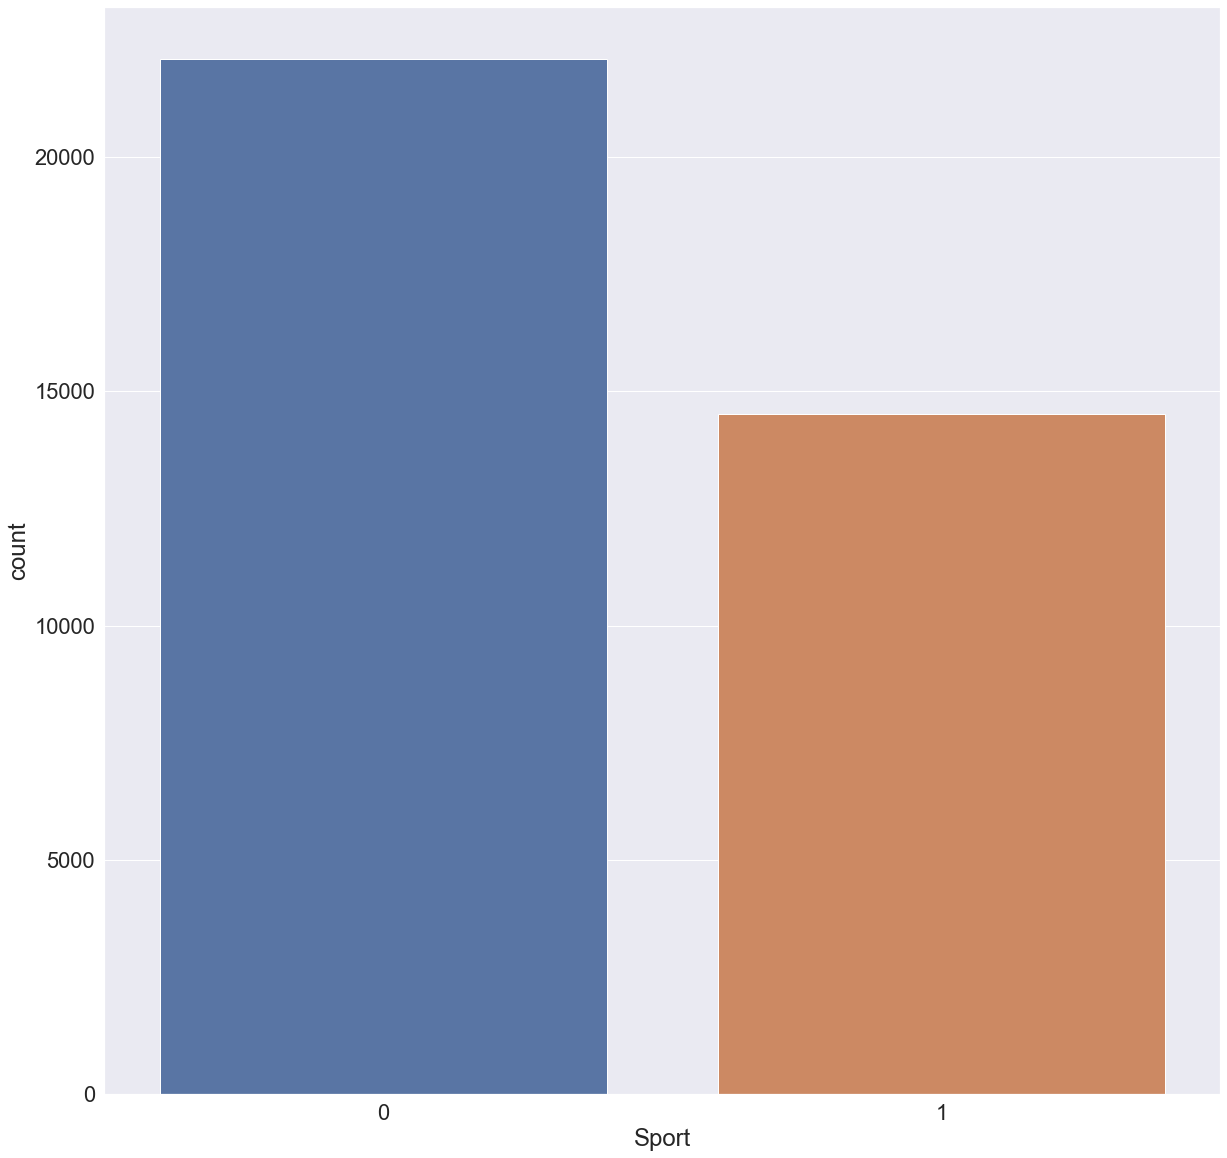

In [59]:
plt.figure(figsize=(20,20))
sns.countplot(df_eda['Sport'])#, 'Trad', 'Boulder', 'TR']])

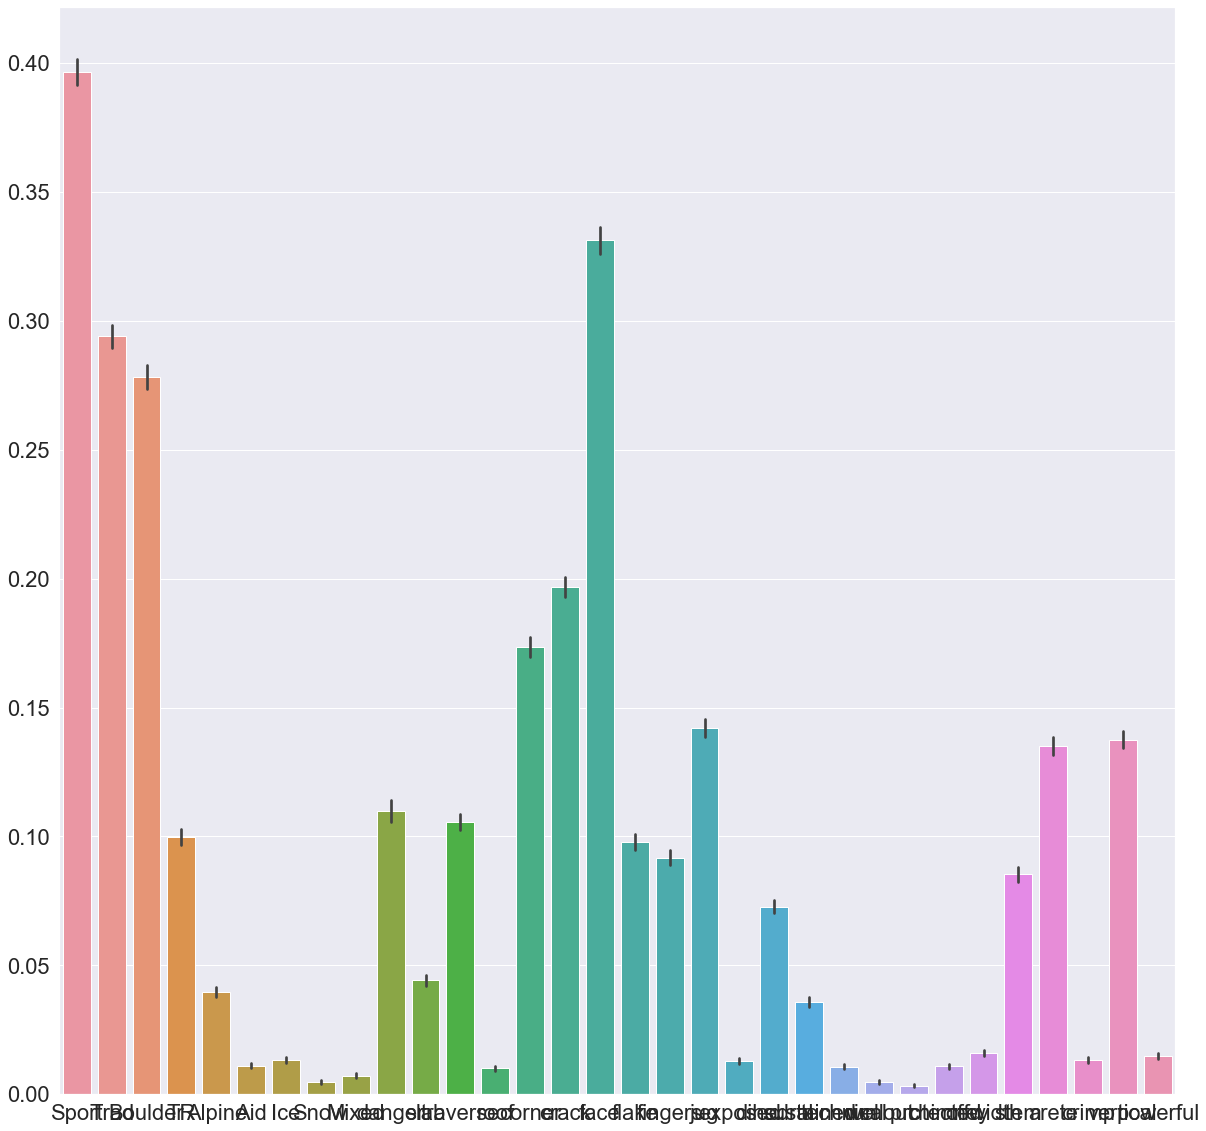

In [60]:
plt.figure(figsize=(20,20))
sns.barplot(data=df_eda)

### Climb Features Distribution

In [61]:
# df_graph = pd.melt(df_eda.loc[:,['Sport', 'Trad', 'Boulder', 'TR']])
df_graph = df_eda.loc[:,['Sport', 'Trad', 'Boulder', 'TR']]

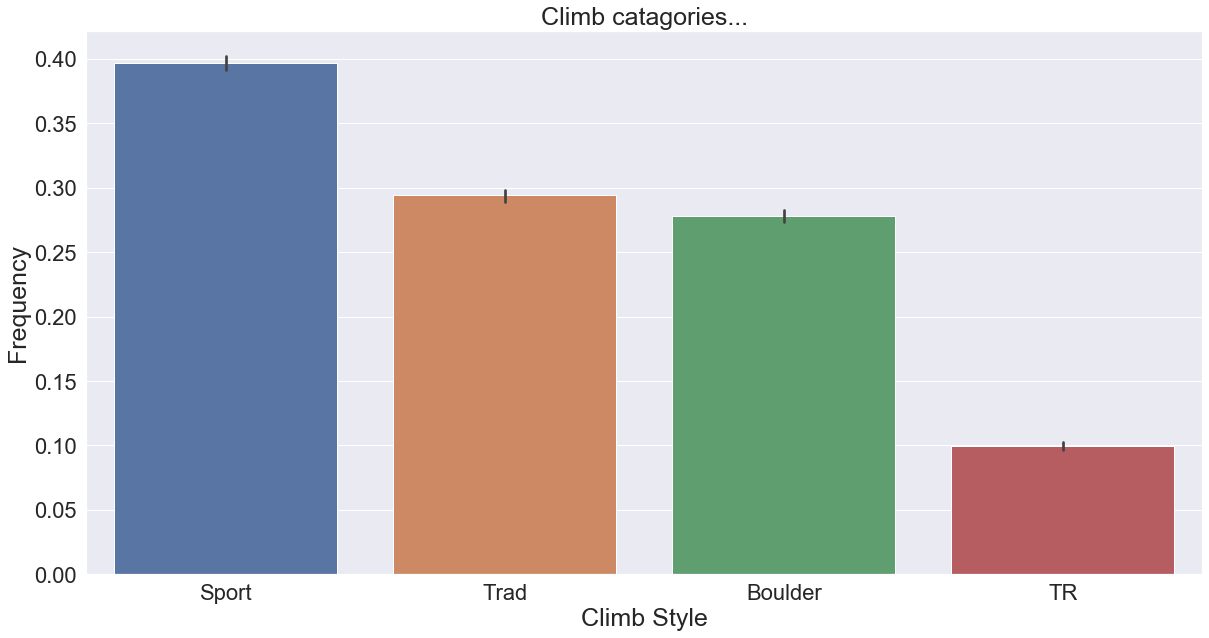

In [62]:
plt.figure(figsize=(20,10))
ax=sns.barplot(data=df_graph)
plt.title('Climb catagories...',fontsize = 25)
plt.xlabel('Climb Style', fontsize = 25)
plt.ylabel('Frequency',fontsize = 25)
# plt.legend(['No','Yes'])
# plt.set_xlabel(fontsize=20);
plt.savefig('climb_type')

In [63]:
df_graph = pd.melt(df_eda.loc[:,['slab', 'traverse', 'roof', 'corner', 'crack',
       'face', 'flake', 'fingers', 'jug', 'exposed', 'dihedral',
       'sustained', 'technical', 'run out', 'well protected', 'chimney',
       'offwidth', 'stem', 'arete', 'crimp', 'vertical', 'powerful']])

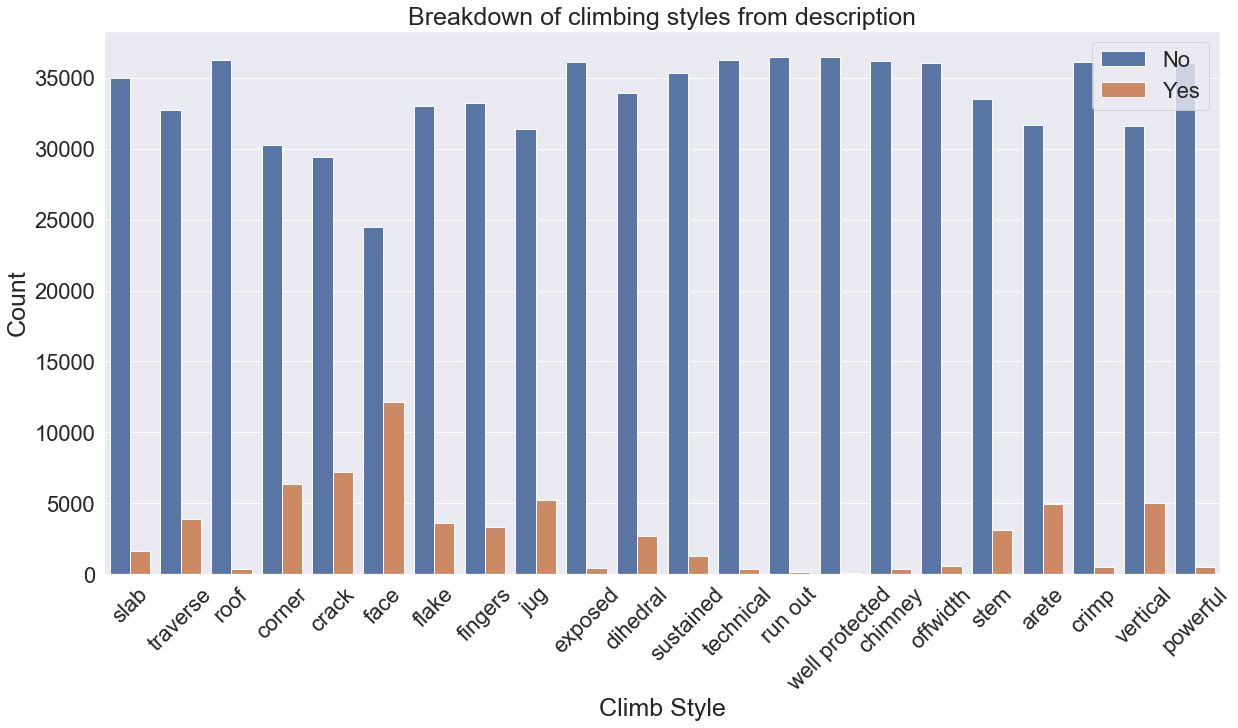

In [64]:
plt.figure(figsize=(20,10))
ax=sns.countplot(x="variable", hue="value", data=df_graph)
plt.title('Breakdown of climbing styles from description',fontsize = 25)
plt.xlabel('Climb Style', fontsize = 25)
plt.ylabel('Count',fontsize = 25)
plt.legend(['No','Yes'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.savefig('climb_description_type')

In [65]:
# sns.factorplot(x='variable', y='value', data=df, kind='bar')

In [66]:
df_numeric[df_numeric.rating.isna()]

,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
105750394,1999,Shooting Star,NaN,4.0,16,1,Colorado,Alpine Rock,Indian Peaks,James Peak,0,-105.689,39.8522,https://www.mountainproject.com/route/10575039...,0,1,0,0,1,0,0,0,0,0,0,0,Shooting Star is an excellent mountaineering r...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
105756508,2671,North Face Couloirs,NaN,4.2,13,1,Colorado,Alpine Rock,Tenmile Range,Pacific Peak,0,-106.123,39.4231,https://www.mountainproject.com/route/10575650...,0,1,0,0,1,0,0,0,0,0,0,0,"From the bottom of the north face, locate a co...",0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
105756727,2695,Dead Dog Couloir,NaN,3.9,45,1,Colorado,Alpine Rock,Torrey's Peak,0,0,-105.821,39.6428,https://www.mountainproject.com/route/10575672...,0,0,0,0,1,0,0,0,0,0,0,0,Dead Dog is the main couloir on the east face ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
105756754,2698,North Star Couloir,NaN,4.5,8,1,Colorado,CO Ice & Mixed,Indian Peaks & James Peak Wilderness Areas,Arapahoe Peaks,0,-105.644,40.0238,https://www.mountainproject.com/route/10575675...,0,1,0,0,0,0,0,0,0,0,0,0,This gem of a snow couloir winds its way up th...,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1
105761478,3099,Audubahn Coulior,NaN,4.0,3,1,Colorado,Alpine Rock,Indian Peaks,Mt. Audubon,0,-105.616,40.0989,https://www.mountainproject.com/route/10576147...,0,1,0,0,1,0,0,0,0,0,0,0,Approach from the north end of Mitchell Lake. ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
105761580,3111,Holy Cross Couloir,NaN,4.1,21,1,Colorado,Alpine Rock,Mount of the Holy Cross,0,0,-106.479,39.4681,https://www.mountainproject.com/route/10576158...,0,0,0,0,1,0,0,0,0,0,0,0,This would be a 3 star rating except it has a ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [67]:
df_numeric.describe()

,orig_index,stars,starVotes,pitches,longitude,latitude,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
count,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.000000,36609.0
mean,18304.000000,3.688486,25.277527,1.044251,-105.704041,39.141836,0.396596,0.293971,0.278101,0.099620,0.039744,0.011063,0.013385,0.004890,0.007211,0.109754,5.740938,4.311317,0.044197,0.105548,0.010079,0.173482,0.196837,0.331476,0.097927,0.091781,0.142205,0.012838,0.072742,0.035865,0.010653,0.004753,0.003305,0.010899,0.015925,0.085362,0.135021,0.013112,0.137562,0.014887,1.0
std,10568.252339,0.818175,59.027575,1.511342,16.242236,3.858649,0.489198,0.455585,0.448070,0.299497,0.195361,0.104598,0.114917,0.069755,0.084614,0.421213,5.314104,8.666622,0.205535,0.307262,0.099891,0.378669,0.397613,0.470750,0.297220,0.288720,0.349266,0.112578,0.259716,0.185957,0.102664,0.068778,0.057397,0.103829,0.125187,0.279423,0.341751,0.113754,0.344444,0.121103,0.0
min,0.000000,0.000000,0.000000,0.000000,-124.353000,29.968500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,9152.000000,3.100000,1.000000,0.000000,-118.571000,36.999200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,18304.000000,3.800000,5.000000,1.000000,-110.720000,38.917400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,27456.000000,4.100000,24.000000,1.000000,-105.118000,41.187500,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,36608.000000,5.000000,1715.000000,36.000000,-68.207700,51.341600,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,17.000000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


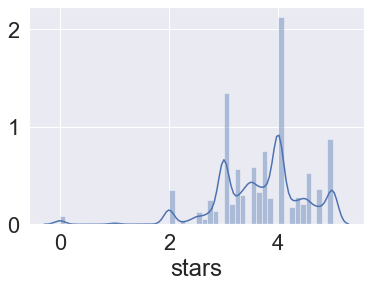

In [68]:
sns.distplot(df_numeric['stars'])

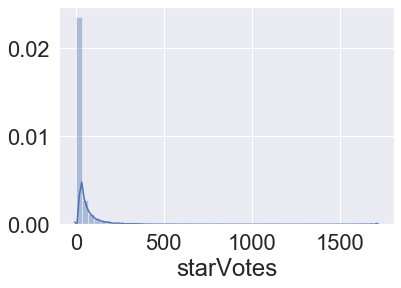

In [69]:
sns.distplot(df_numeric['starVotes'])

In [70]:
df_numeric['pitches'].value_counts()
# plt.xlim(0, 30)     # set the xlim to left, right

1     23017
0      9841
2      1473
3       756
4       515
5       308
6       200
8       114
7       110
9        62
10       60
11       34
12       32
15       19
14       11
13        9
16        9
17        5
19        5
18        4
20        4
22        4
26        3
30        2
35        2
23        2
21        2
36        1
27        1
28        1
33        1
29        1
31        1
Name: pitches, dtype: int64

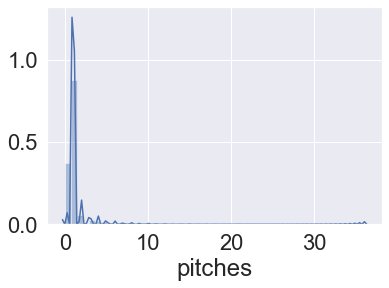

In [71]:
sns.distplot(df_numeric['pitches'])

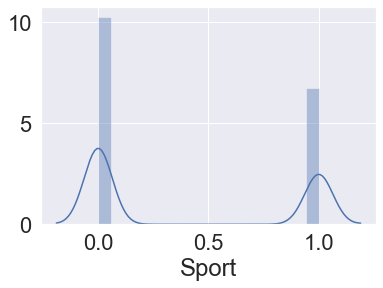

In [72]:
sns.distplot(df_numeric['Sport'])

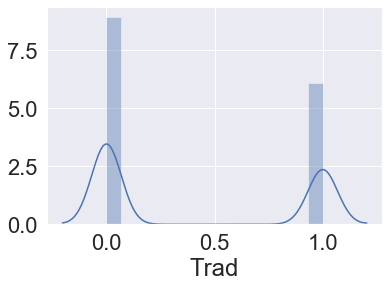

In [73]:
sns.distplot(df_numeric.loc[df_numeric['Boulder']==0,'Trad'])

In [74]:
df_numeric.loc[(df_numeric['Boulder']==0),'name'].count()

26428

In [75]:
df_numeric.loc[(df_numeric['Sport']==1)&(df_numeric['Trad']==1),'name'].count()

622

In [76]:
df_numeric.danger.value_counts()

0    33901
1     1547
2     1012
3      149
Name: danger, dtype: int64

In [78]:
# fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(20,60))
# fig.suptitle('Graphs of Route Descriptions')

# list_of_subplots = np.ravel(axes)

# for ax,col_name in zip(list_of_subplots,features.columns):
#     ax.hist(features[col_name])
#     ax.set_title(f'{col_name} freq')
# fig.savefig('freq_graphs')    #saves fig in current folder

## Reccomender

#### Kernel Imports

In [79]:
# Import kernels
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import chi2_kernel



In [80]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

#### Create fxn to see if climb is in search range

In [81]:
#function takes search param range and assigns to original df if climb in_range
def in_range(df_fxn, lat, lon, radius_range=None):
    if radius_range:
        R= 3958.8 
        if (lat == None)|(lon==None):
            df_fxn['in_range'] = 1
        else:
            #assign target coords and set to radians for calc
            lat1 = radians(lat)
            lon1 = radians(lon)
            for index, row in df_fxn.iterrows():
                #assign the lat and lon for each climb
                lat2 = radians(row['latitude'])
                lon2 = radians(row['longitude'])

                dlon = lon2 - lon1
                dlat = lat2 - lat1

                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))

                distance = R * c

                #assign in_range col to 1 if the climb is in range
                if distance < radius_range:
                    df_fxn.at[index,'in_range']=1
                else:
                    df_fxn.at[index,'in_range']=0   
    else:
        df_fxn['in_range'] =1



In [82]:
def star_cutoff(df_fxn, star_limit=3.5):
    for index, row in df_fxn.iterrows():
        #assign in_range col to 1 if the climb is in range
        if df_fxn.at[index, 'stars'] >= star_limit:
            df_fxn.at[index,'in_range']=1
        else:
            df_fxn.at[index,'in_range']=0   

#### Call function to assign if climb in range

In [83]:
## used to get list of climbs allowed for comparison
in_range(df_numeric, lat = target_lat, lon = target_lon, radius_range=target_radius_range)

#### Star cutoff (ie only give results for routes with above 3.5 stars)

In [84]:
star_cutoff(df_numeric, star_limit)

#### Create df_in_range to run recommender in subset

In [105]:
df_in_range = df_numeric[df_numeric['in_range']==1].reset_index()      #maybe add star filter in this line
target_index =df_in_range.index[df_in_range['id']==target_id][0]
df_in_range.shape

(36609, 51)

### Scale Features

#### Create Features DF

In [130]:
#creates features df used for comparison
features = df_in_range.loc[:,['stars', 'pitches', 'Sport', 'Trad', 'Boulder', 'TR', 'Alpine', 'Aid',
       'Ice', 'Snow', 'Mixed', 'danger', 'rope_grade', 'boulder_grade', 'slab', 'traverse', 'roof', 
                'corner', 'crack', 'face','flake', 'fingers',
                 'jug', 'exposed', 'dihedral', 'sustained', 'technical','run out', 'well protected',
                 'chimney', 'offwidth', 'stem', 'arete','crimp', 'vertical', 'powerful']] #,'longitude','latitude',

In [107]:
# features.to_csv('features.csv')

In [108]:
features.shape

(36609, 36)

In [109]:
# features.iloc[:,13].value_counts()

#### Pick scaling type (AND UPDATE WEIGHTS)

In [110]:
min_max_scaler = MinMaxScaler()
scalar = StandardScaler()

In [176]:
##### Pick a scaling option ###############################

# features_scaled = scalar.fit_transform(features)
features_scaled = min_max_scaler.fit_transform(features.drop(columns=['danger','pitches']))

# scale danger and pitches using ss and add into features scaled df
features_scaled = np.concatenate((features_scaled, scalar.fit_transform(features[['danger', 'pitches']])), axis=1)

##################################################################

#### Add weight for difficulity of climb

In [172]:
features

,stars,pitches,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful
0,4.4,0,0,0,1,1,0,0,0,0,0,2,0,15,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.6,2,1,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4.1,2,0,1,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.9,3,0,1,0,0,0,0,0,0,0,0,11,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,3.5,1,1,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,4.1,1,1,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,4.4,1,1,0,0,1,0,0,0,0,0,0,14,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,3.0,1,1,0,0,1,0,0,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,4.8,1,0,1,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,3.9,1,1,0,0,0,0,0,0,0,0,3,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [179]:
for i in range(features_scaled.shape[0]):
    features_scaled[i][10]=features_scaled[i][10]*5
    features_scaled[i][11]=features_scaled[i][11]*5

### Now lets fit the similarity model

#### Rec function

In [180]:
def get_recommendations(idx, kernel_type):

    #value to store scores and indicies
    score_matrix = np.ndarray(shape=(len(df_in_range),2), dtype=float)

    #go through the target climb vs all onthers in our db and populate score mtx with index and similarity
    for i in range(df_in_range.shape[0]):
        score = kernel_type(features_scaled[idx].reshape(1,-1),features_scaled[i].reshape(1,-1))
        score_matrix[i][0] =  i        ##the index comparison corresponding to the score
        score_matrix[i][1] = score     ##the score for the current index

    # Sort the climbs based on the similarity scores
    score_matrix = sorted(score_matrix, key=lambda x: x[1], reverse=True)
    
    # score_matrix
#########################  ADD/calculate SIMilarity VALUE   ###########################

    # # Get the scores of the 20 most similar climbs
    score_matrix = score_matrix[1:20]

    # # Get the climb indices (& cast to ints)
    climb_indices = [int(i[0]) for i in score_matrix]
    
    # Return the top 20 most similar climbs
    return df_in_range.loc[climb_indices,:]

#### Cells for comparison (delete later)

In [165]:
df_numeric.loc[105721615, :]

orig_index                                                      304
name                                                   Double Cross
rating                                                         5.7+
stars                                                           4.5
starVotes                                                      1271
pitches                                                           1
location                                                 California
region                                    Joshua Tree National Park
area                                       Hidden Valley Campground
sub_area                                              The Old Woman
wall                                      The Old Woman - West Face
longitude                                                  -116.164
latitude                                                    34.0165
url               https://www.mountainproject.com/route/10572161...
Sport                                           

In [166]:
df_numeric.shape

(36609, 50)

In [167]:
target_index

304

In [168]:
# df_numeric[(df_numeric['boulder_grade']>5)]

#### Call rec fxn

In [169]:
pd.options.display.max_columns = None

In [181]:
rec=get_recommendations(target_index, cosine_similarity)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
12888,106799796,12888,Double Trouble,5.5,3.4,28,1,Washington,Southeast Cascades & Yakima,Tieton River,Royal Columns,Main Face,-120.8100,46.7251,https://www.mountainproject.com/route/10679979...,0,1,0,0,0,0,0,0,0,0,9,0,The length of this climb is deceptive from the...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17328,107594097,17328,Parallelogram,5.8,4.0,1,1,Utah,Wasatch Range,Logan,Smithfield Dry Canyon,0,-111.7950,41.7435,https://www.mountainproject.com/route/10759409...,0,1,0,0,0,0,0,0,0,0,14,0,Due to water seepage you have to start out on ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22904,109498932,22904,Bon Temps Rouler,5.9,4.2,27,1,New Hampshire,WM: Kancamagus (Eastern),Sundown Ledge,Main Cliff,0,-71.2393,44.0050,https://www.mountainproject.com/route/10949893...,0,1,0,0,0,0,0,0,0,0,17,0,A really nice moderate crack climb with a lot ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2600,105755581,2600,East Side,5.8+,4.0,46,2,Colorado,Estes Park Valley,Lumpy Ridge,The Bookmark,0,-105.5360,40.4061,https://www.mountainproject.com/route/10575558...,0,1,0,0,0,0,0,0,0,0,14,0,"This route is on Bookmark Pinnacle, which is j...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2818,105758044,2818,Pete and Benz,5.7,3.4,44,2,Colorado,South Platte,Rampart Range Road,Parachute Rock,0,-105.0190,39.1767,https://www.mountainproject.com/route/10575804...,0,1,0,0,0,0,0,0,0,0,11,0,This route is on the left section of the rock....,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5805,105916076,5805,Peking,5.8,3.4,43,2,Oregon,Central Oregon,Smith Rock,(u) Red Wall,0,-121.1390,44.3696,https://www.mountainproject.com/route/10591607...,0,1,0,0,0,0,0,0,0,0,14,0,"First pitch is classic, many stop at first set...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27215,111867265,27215,T.Bam Crack,5.9,3.0,1,1,International,North America,Canada,Alberta,"Banff National Park,Mt. Cory,Take it for Granite",-115.6970,51.1768,https://www.mountainproject.com/route/11186726...,0,1,0,0,0,0,0,0,0,0,17,0,A hand sized crack that can be accessed off th...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32409,115174802,32409,Boner Jam,5.9+,3.0,1,1,Colorado,Buena Vista,Brown's Canyon National Monument,Staircase Towers,0,-106.0310,38.6829,https://www.mountainproject.com/route/11517480...,0,1,0,0,0,0,0,0,0,0,17,0,This route is on the south side of the rock ma...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
13373,106862754,13373,Tribal Therapy,5.8+,5.0,5,1,Washington,Southwest Cascades,Farside / Dropzone,(2) Dropzone Area,0,-122.2060,45.5691,https://www.mountainproject.com/route/10686275...,0,1,0,0,0,0,0,0,0,0,14,0,Great route! Scramble up the broken pillar sec...,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1772,105749056,1772,Nun Buttress,5.8,4.1,22,1,Colorado,Estes Park Valley,Deer Mountain,Deer Ridge Buttress,0,-105.5880,40.3892,https://www.mountainproject.com/route/10574905...,0,1,0,0,0,0,0,0,0,0,14,0,"The route, as good as almost any route of the ...",0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [170]:
rec=get_recommendations(target_index, cosine_similarity)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
17328,107594097,17328,Parallelogram,5.8,4.0,1,1,Utah,Wasatch Range,Logan,Smithfield Dry Canyon,0,-111.7950,41.7435,https://www.mountainproject.com/route/10759409...,0,1,0,0,0,0,0,0,0,0,14,0,Due to water seepage you have to start out on ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12888,106799796,12888,Double Trouble,5.5,3.4,28,1,Washington,Southeast Cascades & Yakima,Tieton River,Royal Columns,Main Face,-120.8100,46.7251,https://www.mountainproject.com/route/10679979...,0,1,0,0,0,0,0,0,0,0,9,0,The length of this climb is deceptive from the...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22904,109498932,22904,Bon Temps Rouler,5.9,4.2,27,1,New Hampshire,WM: Kancamagus (Eastern),Sundown Ledge,Main Cliff,0,-71.2393,44.0050,https://www.mountainproject.com/route/10949893...,0,1,0,0,0,0,0,0,0,0,17,0,A really nice moderate crack climb with a lot ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12114,106672951,12114,Creature from the Black Lagoon,5.10c,4.5,22,1,California,Yosemite National Park,Tuolumne Meadows,Olmsted Area,Olmsted Canyon Left,-119.4900,37.8135,https://www.mountainproject.com/route/10667295...,0,1,0,0,0,0,0,0,0,0,5,0,"A novelty route mostly, traverse along a flari...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25271,110865961,25271,Center Route P3 Variation,5.10a,4.7,14,1,Colorado,South Platte,Cathedral Spires Area,Cynical Pinnacle,0,-105.2520,39.4206,https://www.mountainproject.com/route/11086596...,0,1,0,0,0,0,0,0,0,0,5,0,This pitch is a fine option for those that wan...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
31344,114278058,31344,Smear Campaign,5.13+,4.0,1,1,Colorado,Grand Junction Area,Unaweep Canyon,Main Canyon: Unaweep Granite,"The Access Fund Trailhead,Sunday Wall",-108.6080,38.8183,https://www.mountainproject.com/route/11427805...,0,1,0,0,0,0,0,0,0,0,5,0,This is a fun route that has it all. It starts...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24545,110504128,24545,Sharon's crack,5.10a,3.9,8,1,Utah,Capitol Reef National Park,Terrible Twos Wall,0,0,-111.2480,38.2843,https://www.mountainproject.com/route/11050412...,0,1,0,0,0,0,0,0,0,0,5,0,Climbs the left leaning crack 30 feet right fr...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16971,107505636,16971,Mr. Clean,5.10c,3.8,8,1,California,Lake Tahoe,I-80 Corridor,Donner Summit,"Black Wall,2. Black Wall - Center",-120.3140,39.3251,https://www.mountainproject.com/route/10750563...,0,1,0,0,0,0,0,0,0,0,5,0,Awesome route (when it's clean). Bouldery sta...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3028,105760719,3028,Dead Boy,5.10b,3.6,16,1,Colorado,Estes Park Valley,Lumpy Ridge,The Book,Isis Buttress,-105.5350,40.4062,https://www.mountainproject.com/route/10576071...,0,1,0,0,0,0,0,0,0,0,5,0,This route is the first 20-25 feet of the Dire...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27215,111867265,27215,T.Bam Crack,5.9,3.0,1,1,International,North America,Canada,Alberta,"Banff National Park,Mt. Cory,Take it for Granite",-115.6970,51.1768,https://www.mountainproject.com/route/11186726...,0,1,0,0,0,0,0,0,0,0,17,0,A hand sized crack that can be accessed off th...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [171]:
rec=get_recommendations(target_index, rbf_kernel)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
17328,107594097,17328,Parallelogram,5.8,4.0,1,1,Utah,Wasatch Range,Logan,Smithfield Dry Canyon,0,-111.7950,41.7435,https://www.mountainproject.com/route/10759409...,0,1,0,0,0,0,0,0,0,0,14,0,Due to water seepage you have to start out on ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12888,106799796,12888,Double Trouble,5.5,3.4,28,1,Washington,Southeast Cascades & Yakima,Tieton River,Royal Columns,Main Face,-120.8100,46.7251,https://www.mountainproject.com/route/10679979...,0,1,0,0,0,0,0,0,0,0,9,0,The length of this climb is deceptive from the...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12114,106672951,12114,Creature from the Black Lagoon,5.10c,4.5,22,1,California,Yosemite National Park,Tuolumne Meadows,Olmsted Area,Olmsted Canyon Left,-119.4900,37.8135,https://www.mountainproject.com/route/10667295...,0,1,0,0,0,0,0,0,0,0,5,0,"A novelty route mostly, traverse along a flari...",0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25271,110865961,25271,Center Route P3 Variation,5.10a,4.7,14,1,Colorado,South Platte,Cathedral Spires Area,Cynical Pinnacle,0,-105.2520,39.4206,https://www.mountainproject.com/route/11086596...,0,1,0,0,0,0,0,0,0,0,5,0,This pitch is a fine option for those that wan...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22904,109498932,22904,Bon Temps Rouler,5.9,4.2,27,1,New Hampshire,WM: Kancamagus (Eastern),Sundown Ledge,Main Cliff,0,-71.2393,44.0050,https://www.mountainproject.com/route/10949893...,0,1,0,0,0,0,0,0,0,0,17,0,A really nice moderate crack climb with a lot ...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
31344,114278058,31344,Smear Campaign,5.13+,4.0,1,1,Colorado,Grand Junction Area,Unaweep Canyon,Main Canyon: Unaweep Granite,"The Access Fund Trailhead,Sunday Wall",-108.6080,38.8183,https://www.mountainproject.com/route/11427805...,0,1,0,0,0,0,0,0,0,0,5,0,This is a fun route that has it all. It starts...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24545,110504128,24545,Sharon's crack,5.10a,3.9,8,1,Utah,Capitol Reef National Park,Terrible Twos Wall,0,0,-111.2480,38.2843,https://www.mountainproject.com/route/11050412...,0,1,0,0,0,0,0,0,0,0,5,0,Climbs the left leaning crack 30 feet right fr...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16971,107505636,16971,Mr. Clean,5.10c,3.8,8,1,California,Lake Tahoe,I-80 Corridor,Donner Summit,"Black Wall,2. Black Wall - Center",-120.3140,39.3251,https://www.mountainproject.com/route/10750563...,0,1,0,0,0,0,0,0,0,0,5,0,Awesome route (when it's clean). Bouldery sta...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3028,105760719,3028,Dead Boy,5.10b,3.6,16,1,Colorado,Estes Park Valley,Lumpy Ridge,The Book,Isis Buttress,-105.5350,40.4062,https://www.mountainproject.com/route/10576071...,0,1,0,0,0,0,0,0,0,0,5,0,This route is the first 20-25 feet of the Dire...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27215,111867265,27215,T.Bam Crack,5.9,3.0,1,1,International,North America,Canada,Alberta,"Banff National Park,Mt. Cory,Take it for Granite",-115.6970,51.1768,https://www.mountainproject.com/route/11186726...,0,1,0,0,0,0,0,0,0,0,17,0,A hand sized crack that can be accessed off th...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [122]:
rec=get_recommendations(target_index, laplacian_kernel)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
1831,105749344,1831,The Cave Exit,5.7+,3.6,129,1,Colorado,Estes Park Valley,Lumpy Ridge,The Book,J-Crack Slab Area,-105.5340,40.4056,https://www.mountainproject.com/route/10574934...,0,1,0,0,0,0,0,0,0,0,11,0,This route is the standard finish to climbs on...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2818,105758044,2818,Pete and Benz,5.7,3.4,44,2,Colorado,South Platte,Rampart Range Road,Parachute Rock,0,-105.0190,39.1767,https://www.mountainproject.com/route/10575804...,0,1,0,0,0,0,0,0,0,0,11,0,This route is on the left section of the rock....,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1358,105741227,1358,Main Crack,5.7,4.5,133,1,Utah,Wasatch Range,Rock Canyon,Ed and Terry Wall,0,-111.6230,40.2645,https://www.mountainproject.com/route/10574122...,0,1,0,0,0,0,0,0,0,0,11,0,This is a great route that screams to all clim...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
14420,107049614,14420,Center Dinosaur Crack,5.7,4.2,41,1,California,Sierra Eastside,Lone Pine Area,Alabama Hills,"Cattle Pocket and Corridors Area,Dinosaur Cracks",-118.1300,36.6032,https://www.mountainproject.com/route/10704961...,0,1,0,0,0,0,0,0,0,0,11,0,This is the nice hand crack in the center.-Gea...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
311,105721639,311,Geronimo,5.7,4.0,127,1,California,Joshua Tree National Park,Hidden Valley Campground,The Old Woman,The Old Woman - East Face,-116.1640,34.0167,https://www.mountainproject.com/route/10572163...,0,1,0,0,0,0,0,0,0,0,11,0,I'm sure there are many ways to get to this ro...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
384,105721969,384,White Lightning,5.7,4.0,701,1,California,Joshua Tree National Park,Lost Horse Area,Hemingway Buttress,Hemingway Buttress (East Face Left),-116.1780,34.0239,https://www.mountainproject.com/route/10572196...,0,1,0,0,0,0,0,0,0,0,11,0,Near the left side of the wall is this hand/fi...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25549,111036084,25549,Lizard Princess,5.7,4.0,2,1,California,Sierra Eastside,Lee Vining Canyon / Tioga Road,Dinosaur Crag,0,-119.2260,37.9377,https://www.mountainproject.com/route/11103608...,0,1,0,0,0,0,0,0,0,0,11,0,Clean hand crack with the well-protected 5.7 c...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32650,115401354,32650,Short But Sweet,5.7,4.0,1,1,Colorado,Buena Vista,A Wonderful World,0,0,-106.1090,38.8590,https://www.mountainproject.com/route/11540135...,0,1,0,0,0,0,0,0,0,0,11,0,Climb a weakness to the base of a splitter han...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
33815,116598226,33815,Lost Hands,5.7+,4.0,1,1,California,Central Coast,Santa Barbara,The Playground,Land of the Lost,-119.8460,34.5010,https://www.mountainproject.com/route/11659822...,0,1,0,0,0,0,0,0,0,0,11,0,"As my brother might say, the crux is deciding ...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6269,105947967,6269,VH-1,5.7,3.9,81,1,New Hampshire,WM: Franconia Notch,Echo Crag,1. Square Inch Wall,0,-71.6895,44.1780,https://www.mountainproject.com/route/10594796...,0,1,0,0,0,0,0,0,0,0,11,0,VH-1 is one of the best routes on Square Inch ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [102]:
rec=get_recommendations(target_index, euclidean_distances)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
25580,111057266,25580,Laces Out aka Houdini Traverse,V9,0.0,0,0,California,Redwood Coast,Houda Point,Houda North,0,-124.1190,41.0359,https://www.mountainproject.com/route/11105726...,0,0,1,0,0,0,0,0,0,0,0,39,from start of houda crack traverse right to th...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
17568,107648102,17568,Yabo Squeeze,V9,3.0,1,0,California,San Francisco Bay Area,Castle Rock Area,* Castle Rock Area Bouldering,"Castle Rock Loop,Parking Lot Rock",-122.0950,37.2296,https://www.mountainproject.com/route/10764810...,0,0,1,0,0,0,0,0,0,0,0,39,This is a squeeze job and quasi eliminate betw...,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
27001,111798944,27001,Breaker of Chains,V9,3.0,1,0,Massachusetts,Charlemont,Upper Field,0,0,-72.7751,42.7223,https://www.mountainproject.com/route/11179894...,0,0,1,0,0,0,0,0,0,0,0,39,Start standing with a right hand on a sloping ...,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
17323,107591323,17323,The Graduate,V9,4.0,1,0,Colorado,Gunnison,Taylor Canyon,Taylor Canyon Bouldering,Esty Lane Boulders,-106.7420,38.7327,https://www.mountainproject.com/route/10759132...,0,0,1,0,0,0,0,0,0,0,0,39,Stand start in the rubble on a huge undercling...,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3125,105761781,3125,One Ton Ho,V9,4.2,5,0,Colorado,Fort Collins,Poudre Canyon,West of Rustic,"420s,Hank's Boulder",-105.8060,40.6731,https://www.mountainproject.com/route/10576178...,0,0,1,0,0,0,0,0,0,0,0,39,This is located on the Hank's Boulder. It the...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1
11348,106566855,11348,Bierstadt,V9+,4.9,18,0,Colorado,Alpine Rock,Mt. Evans,Mt. Evans Bouldering,"Area A,Bierstadt Area",-105.6210,39.6326,https://www.mountainproject.com/route/10656685...,0,0,1,0,1,0,0,0,0,0,0,39,"Originally considered V10, the variety of diff...",0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
10673,106476136,10673,Deep Puddle Dynamics,V9+,4.8,12,0,Colorado,Alpine Rock,RMNP - Rock,RMNP Bouldering Areas,"Chaos Canyon Bouldering,Lower Chaos Canyon,Dee...",-105.6610,40.3048,https://www.mountainproject.com/route/10647613...,0,0,1,0,1,0,0,0,0,0,0,39,Perfect slopers on a gently overhanging face. ...,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
21238,108561805,21238,Linder's Roof,V9,4.4,11,0,Utah,Saint George,Moe's Valley,Tee Pee Area,Ripple,-113.6300,37.0655,https://www.mountainproject.com/route/10856180...,0,0,1,0,0,0,0,0,0,0,0,39,Hard moves right off the ground to an amazing ...,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
27203,111866060,27203,The Carnivore Stand,V9,2.0,1,0,Massachusetts,Charlemont,Upper Field,0,0,-72.7751,42.7223,https://www.mountainproject.com/route/11186606...,0,0,1,0,0,0,0,0,0,0,0,39,Start with your right hand on a full pad under...,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
15647,107273813,15647,Red Dwarf,V9,2.5,2,0,New Mexico,Socorro Area,The Box Climbing Areas,Spook Canyon,Spook Outlying Boulders,-106.9820,34.0002,https://www.mountainproject.com/route/10727381...,0,0,1,0,0,0,0,0,0,0,0,39,Starting low on a right hand slot and left han...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [103]:
rec=get_recommendations(target_index, linear_kernel)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
2060,105750802,2060,Fool's Gold,5.9+,4.5,17,2,Colorado,South Platte,Goose Creek/Molly Gulch Campground,Helen's Dome,0,-105.3350,39.1887,https://www.mountainproject.com/route/10575080...,1,1,0,0,0,0,0,0,0,0,17,0,Start off the ramp about 30 feet left of the l...,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
7452,106049635,7452,W.A.S.P. (center variation start),5.9+,4.4,44,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Hornets Nest,-103.4670,43.8864,https://www.mountainproject.com/route/10604963...,1,1,0,0,0,0,0,0,0,0,17,0,This is a nice solid 5.9 which is consistent a...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
21918,108935327,21918,Captain Hook,5.9 PG13,4.4,7,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Sharks Fin,-103.4670,43.8863,https://www.mountainproject.com/route/10893532...,1,1,0,0,0,0,0,0,0,1,17,0,Starts on left to right angling dike. Clip bol...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1167,105738359,1167,Fort Stress,5.9+,4.3,52,4,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Mount Lemmon (Catalina Highway),"8 - Summit Crags,The Fortress,Southeast Face",-110.7980,32.4321,https://www.mountainproject.com/route/10573835...,1,0,0,0,0,0,0,0,0,0,17,0,"This route is long, fun, reasonably safe, high...",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22675,109364756,22675,D4,5.9+,4.2,62,6,Colorado,Buena Vista,Davis Face,0,0,-106.1050,38.9174,https://www.mountainproject.com/route/10936475...,1,0,0,0,0,0,0,0,0,0,17,0,D4 is a beautiful route on the right side of t...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
31316,114262472,31316,Void of Form,5.9,4.0,47,10,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Pontatoc Canyon,Pontatoc Ridge,-110.8880,32.3454,https://www.mountainproject.com/route/11426247...,1,0,0,0,0,0,0,0,0,0,17,0,Void of Form climbs the long buttress of rock ...,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
25125,110794133,25125,Guava Jelly,5.9+,4.1,29,1,Utah,Moab Area,La Sal Mountains,Upper Dakota Crag,Trenchtown,-109.2740,38.4703,https://www.mountainproject.com/route/11079413...,1,0,0,0,0,0,0,0,0,0,17,0,An unbelievable dihedral climb with lots of sm...,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
6358,105956634,6358,Camel Toe,5.9+,4.0,38,6,Colorado,Estes Park Valley,Fall River Road (US 34 West),McGregor Slab,0,-105.5850,40.4085,https://www.mountainproject.com/route/10595663...,1,1,0,0,0,0,0,0,0,0,17,0,This is a writeup is based upon firsthand expe...,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7289,106028627,7289,Rock Du Jours Direct,5.9+,4.0,179,2,New Hampshire,*Rumney,Main Cliff,0,0,-71.8359,43.8025,https://www.mountainproject.com/route/10602862...,1,0,0,0,0,0,0,0,0,0,17,0,This is perhaps one of the best 5.9s at Rumney...,1,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
1097,105737426,1097,Thin Man,5.9 R,4.0,29,1,California,Central Coast,San Luis Obispo,Bishop Peak,Shadow Rock,-120.6960,35.3037,https://www.mountainproject.com/route/10573742...,1,0,0,0,0,0,0,0,0,2,17,0,The last route to the left of Shadow before yo...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [107]:
rec=get_recommendations(target_index, polynomial_kernel)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
792,105750802,2060,Fool's Gold,5.9+,4.5,17,2,Colorado,South Platte,Goose Creek/Molly Gulch Campground,Helen's Dome,0,-105.3350,39.1887,https://www.mountainproject.com/route/10575080...,1,1,0,0,0,0,0,0,0,0,17,0,Start off the ramp about 30 feet left of the l...,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
3066,106049635,7452,W.A.S.P. (center variation start),5.9+,4.4,44,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Hornets Nest,-103.4670,43.8864,https://www.mountainproject.com/route/10604963...,1,1,0,0,0,0,0,0,0,0,17,0,This is a nice solid 5.9 which is consistent a...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9047,108935327,21918,Captain Hook,5.9 PG13,4.4,7,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Sharks Fin,-103.4670,43.8863,https://www.mountainproject.com/route/10893532...,1,1,0,0,0,0,0,0,0,1,17,0,Starts on left to right angling dike. Clip bol...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
441,105738359,1167,Fort Stress,5.9+,4.3,52,4,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Mount Lemmon (Catalina Highway),"8 - Summit Crags,The Fortress,Southeast Face",-110.7980,32.4321,https://www.mountainproject.com/route/10573835...,1,0,0,0,0,0,0,0,0,0,17,0,"This route is long, fun, reasonably safe, high...",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9382,109364756,22675,D4,5.9+,4.2,62,6,Colorado,Buena Vista,Davis Face,0,0,-106.1050,38.9174,https://www.mountainproject.com/route/10936475...,1,0,0,0,0,0,0,0,0,0,17,0,D4 is a beautiful route on the right side of t...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
10565,110794133,25125,Guava Jelly,5.9+,4.1,29,1,Utah,Moab Area,La Sal Mountains,Upper Dakota Crag,Trenchtown,-109.2740,38.4703,https://www.mountainproject.com/route/11079413...,1,0,0,0,0,0,0,0,0,0,17,0,An unbelievable dihedral climb with lots of sm...,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
13591,114262472,31316,Void of Form,5.9,4.0,47,10,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Pontatoc Canyon,Pontatoc Ridge,-110.8880,32.3454,https://www.mountainproject.com/route/11426247...,1,0,0,0,0,0,0,0,0,0,17,0,Void of Form climbs the long buttress of rock ...,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
2676,105956634,6358,Camel Toe,5.9+,4.0,38,6,Colorado,Estes Park Valley,Fall River Road (US 34 West),McGregor Slab,0,-105.5850,40.4085,https://www.mountainproject.com/route/10595663...,1,1,0,0,0,0,0,0,0,0,17,0,This is a writeup is based upon firsthand expe...,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2999,106028627,7289,Rock Du Jours Direct,5.9+,4.0,179,2,New Hampshire,*Rumney,Main Cliff,0,0,-71.8359,43.8025,https://www.mountainproject.com/route/10602862...,1,0,0,0,0,0,0,0,0,0,17,0,This is perhaps one of the best 5.9s at Rumney...,1,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
429,105737426,1097,Thin Man,5.9 R,4.0,29,1,California,Central Coast,San Luis Obispo,Bishop Peak,Shadow Rock,-120.6960,35.3037,https://www.mountainproject.com/route/10573742...,1,0,0,0,0,0,0,0,0,2,17,0,The last route to the left of Shadow before yo...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [108]:
rec=get_recommendations(target_index, sigmoid_kernel)
rec

,id,orig_index,name,rating,stars,starVotes,pitches,location,region,area,sub_area,wall,longitude,latitude,url,Sport,Trad,Boulder,TR,Alpine,Aid,Ice,Snow,Mixed,danger,rope_grade,boulder_grade,infos,slab,traverse,roof,corner,crack,face,flake,fingers,jug,exposed,dihedral,sustained,technical,run out,well protected,chimney,offwidth,stem,arete,crimp,vertical,powerful,in_range
792,105750802,2060,Fool's Gold,5.9+,4.5,17,2,Colorado,South Platte,Goose Creek/Molly Gulch Campground,Helen's Dome,0,-105.3350,39.1887,https://www.mountainproject.com/route/10575080...,1,1,0,0,0,0,0,0,0,0,17,0,Start off the ramp about 30 feet left of the l...,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1
3066,106049635,7452,W.A.S.P. (center variation start),5.9+,4.4,44,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Hornets Nest,-103.4670,43.8864,https://www.mountainproject.com/route/10604963...,1,1,0,0,0,0,0,0,0,0,17,0,This is a nice solid 5.9 which is consistent a...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9047,108935327,21918,Captain Hook,5.9 PG13,4.4,7,1,South Dakota,The Needles Of Rushmore,Mount Rushmore National Memorial,South Seas,Sharks Fin,-103.4670,43.8863,https://www.mountainproject.com/route/10893532...,1,1,0,0,0,0,0,0,0,1,17,0,Starts on left to right angling dike. Clip bol...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
441,105738359,1167,Fort Stress,5.9+,4.3,52,4,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Mount Lemmon (Catalina Highway),"8 - Summit Crags,The Fortress,Southeast Face",-110.7980,32.4321,https://www.mountainproject.com/route/10573835...,1,0,0,0,0,0,0,0,0,0,17,0,"This route is long, fun, reasonably safe, high...",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9382,109364756,22675,D4,5.9+,4.2,62,6,Colorado,Buena Vista,Davis Face,0,0,-106.1050,38.9174,https://www.mountainproject.com/route/10936475...,1,0,0,0,0,0,0,0,0,0,17,0,D4 is a beautiful route on the right side of t...,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
10565,110794133,25125,Guava Jelly,5.9+,4.1,29,1,Utah,Moab Area,La Sal Mountains,Upper Dakota Crag,Trenchtown,-109.2740,38.4703,https://www.mountainproject.com/route/11079413...,1,0,0,0,0,0,0,0,0,0,17,0,An unbelievable dihedral climb with lots of sm...,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
13591,114262472,31316,Void of Form,5.9,4.0,47,10,Arizona,Southern Arizona,Mount Lemmon (Santa Catalina Mountains),Pontatoc Canyon,Pontatoc Ridge,-110.8880,32.3454,https://www.mountainproject.com/route/11426247...,1,0,0,0,0,0,0,0,0,0,17,0,Void of Form climbs the long buttress of rock ...,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
2676,105956634,6358,Camel Toe,5.9+,4.0,38,6,Colorado,Estes Park Valley,Fall River Road (US 34 West),McGregor Slab,0,-105.5850,40.4085,https://www.mountainproject.com/route/10595663...,1,1,0,0,0,0,0,0,0,0,17,0,This is a writeup is based upon firsthand expe...,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2999,106028627,7289,Rock Du Jours Direct,5.9+,4.0,179,2,New Hampshire,*Rumney,Main Cliff,0,0,-71.8359,43.8025,https://www.mountainproject.com/route/10602862...,1,0,0,0,0,0,0,0,0,0,17,0,This is perhaps one of the best 5.9s at Rumney...,1,1,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1
429,105737426,1097,Thin Man,5.9 R,4.0,29,1,California,Central Coast,San Luis Obispo,Bishop Peak,Shadow Rock,-120.6960,35.3037,https://www.mountainproject.com/route/10573742...,1,0,0,0,0,0,0,0,0,2,17,0,The last route to the left of Shadow before yo...,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
# rec=get_recommendations(climb_id, chi2_kernel)
# rec

## NLP 

### Import NLP Data (redundent delete later)

In [ ]:
df_nlp = query_helper.query_to_df('SELECT * FROM route_description;')
df_nlp.set_index('id', inplace=True)
df_nlp.head()

In [ ]:
key_words = ['slab', 'traverse', 'roof', 'corner', 'ledge', 'crack', 'face','flake', 'finger', 'fingers',
             'hand', 'hands', 'arch', 'balancy', 'balance', 'jug', 'squeeze', 'mantel', 'sustained',  
             'ramp', 'overhung', 'dihedral', 'sporty', 'heady', 'pump', 'pumpy', 'technical',
             'run out', 'mental', 'well protected', 'chimney', 'offwidth', 'stem', 'arete', 'exposed', 'exposure',
             'crimp','crimpy', 'vertical', 'slabby', 'cave', 'steep', 'bouldery'. 'powerful']

In [ ]:
col_key_words = ['slab', 'traverse', 'roof', 'corner', 'ledge', 'crack', 'face','flake', 'finger',
             'hand', 'arch', 'balancy', 'jug', 'squeeze', 'mantel', 'exposed', 
             'ramp', 'overhung', 'dihedral', 'sporty', 'sustained','pump', 'technical',
             'run out', 'mental', 'well protected', 'chimney', 'offwidth', 'stem', 'arete',
             'crimp', 'vertical', 'cave', 'steep', 'bouldery', 'powerful']

In [ ]:
df_numeric

In [ ]:
df_full = df_numeric.join(df_nlp)
df_full.head()

In [ ]:
df_numeric.head()

### Break descriptions into rope and boulder

#### Rope

In [ ]:
df_sub = df_numeric[(df_numeric['Boulder']==0)]
df_sub = df_sub[(df_numeric['Ice']==0)]
df_sub = df_sub[(df_numeric['Snow']==0)]

df_sub.head()

In [ ]:
df_sub.Boulder.value_counts()

In [ ]:
len(df_sub.index)

In [ ]:
len(df_nlp.loc[df_sub.index])

In [ ]:
nlp_rope =df_nlp.loc[df_sub.index]

In [ ]:
nlp_rope.head()

#### Boulder

#### Tokenizer

In [154]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [ ]:
extra_stop = ['climb','climbing', 'crux', 'rope', 'leave', 'use', 'start', 'end',
              'look', 'rock', 'tree', 'follow', 'continue', 'belay', 'photo', 'add', 'climber', 'route', 
              'lot', 'anchor', '...', '1', '2', '3', '4', '--', 'pitch', 'page', 'cold', 'hot', 'warm',
              'belayer', 'fun', 'like', 'unknown', 'rap', 'left', 'right', 'wide', 'leader']


In [ ]:
for word in extra_stop:
    stop_words.add(word)

In [ ]:
stop_words

In [155]:
# Creating our tokenizer function
def spacy_tokenizer(text):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(text)
    
#     mytokens = [word for word in mytokens if word.pos_ != "PROPN"]
    
    mytokens = [ word if word.pos_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### TF-IDF Vectorizer

#### Run the vectorizer

In [166]:
df_nlp.loc[105714722,:]

infos    The Central Yellow Wall is a classic must-do p...
Name: 105714722, dtype: object

In [169]:
df_nlp[df_nlp.isna().values]

,infos
id,
117568267,NaN


In [157]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=.7)


#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_nlp['infos'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

ValueError: np.nan is an invalid document, expected byte or unicode string.

#### Save it to load later

In [ ]:
# Save the trained model as a pickle string. 
from sklearn.externals import joblib 
import pickle
tfidf_5_7 = pickle.dumps(tfidf_matrix) 

  
# Save the model as a pickle in a file 
joblib.dump(tfidf_matrix, 'tfidf_5_7.pkl') 
  
# Load the model from the file 
# tfidf_loaded = joblib.load('tfidf_5_7.pkl')  
  

### Get original index

In [ ]:
#get index to iterate over
search_range = df_in_range.orig_index

# get index for target in reference to whole matrix
nlp_target_index = int(df_in_range.orig_index[df_in_range['id']==target_id].values)
print('target_index:',nlp_target_index)

In [ ]:
df_nlp.loc[105793305]

In [ ]:
######NEED TO COMBINE WITH get_recommendations so we can get average weighted score#########################
def get_recommendations_for_nlp(idx, kernel_type):

    #value to store scores and indicies
    score_matrix = np.ndarray(shape=(len(df_in_range),2), dtype=float)
    
    for iter_,i in enumerate(search_range.values):
        score = kernel_type(tfidf_matrix[idx],tfidf_matrix[i])
        score_matrix[iter_][0] =  i        ##the index comparison corresponding to the score
        score_matrix[iter_][1] = score     ##the score for the current index

    # Sort the climbs based on the similarity scores
    score_matrix = sorted(score_matrix, key=lambda x: x[1], reverse=True)
    
    # score_matrix
#########################  ADD/calculate SIMilarity VALUE   ###########################

    # # Get the scores of the 20 most similar climbs
    score_matrix = score_matrix[1:20]

    # # Get the climb indices (& cast to ints)
    climb_indices = [int(i[0]) for i in score_matrix]
    
    # Return the top 20 most similar climbs
    return df_numeric.iloc[climb_indices,:]

In [ ]:
rec = get_recommendations_for_nlp(nlp_target_index, cosine_similarity)
rec

In [ ]:
df_nlp.loc[rec.index]

### LDA

#### CV

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(tokenizer=spacy_tokenizer, max_df=0.90, min_df=5, stop_words='english', ngram_range=(1,1))

In [ ]:
dtm = cv.fit_transform(nlp_rope['info'].sample(n=1000, random_state=1))

#### LDA Model

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=32,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

print(lda_model)  # Model attributes

In [ ]:
# This can take awhile, we're dealing with a large amount of documents!

lda_output = lda_model.fit_transform(dtm)


#### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.



In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(dtm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(dtm))

# See model parameters
print(lda_model.get_params())

In [ ]:
len(lda_model.components_)

In [ ]:
single_topic = lda_model.components_[0]

In [ ]:
top_word_indices = single_topic.argsort()[-10:]

In [ ]:
for index in top_word_indices:
    print(cv.get_feature_names()[index])

#### Top words for all groups

In [ ]:
for index,topic in enumerate(lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-30:]])
    print('\n')

In [ ]:
extra_stop = ['climb','climbing', 'crux', 'rope', 'leave', 'use', 'start', 'end',
              'look', 'rock', 'tree', 'follow', 'continue', 'belay', 'photo', 'add', 'climber', 'route', 
              'lot', 'anchor', '...', '1', '2', '3', '4', '--', 'pitch', 'page', 'cold', 'hot', 'warm',
              'belayer', 'fun', 'like', 'unknown', 'rap', 'left', 'right']



### Try new reverse tokenizer

In [ ]:
key_words = ['slab', 'traverse', 'roof', 'corner', 'ledge', 'crack', 'face','flake', 'bolt', 'finger', 'fingers'
             'cam', 'camalot', 'hand', 'hands', 'arch', 'balancy', 'jug', 'squeeze', 'mantel', 'sustained', 'nut', 
             'gear', 'ramp', 'overhung', 'balance', 'dihedral', 'sporty', 'heady', 'pump', 'pumpy', 'technical',
             'run out', 'mental', 'well protected', 'chimney', 'offwidth', 'stem', 'arete', 'exposed', 'exposure',
             'crimp','crimpy', 'vertical', 'slabby', 'cave', 'steep', 'sidepull','bouldery']

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer_reverse(text):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(text)
    
#     mytokens = [word for word in mytokens if word.pos_ != "PROPN"]
    
    mytokens = [ word if word.pos_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    #grab only my key words
    my_sub_tokens =[]
    for word in set(mytokens):
        if word in key_words:
            my_sub_tokens.append(word)

    # return preprocessed list of tokens
    return my_sub_tokens

#### CV

In [ ]:
cv = CountVectorizer(tokenizer=spacy_tokenizer_reverse,  stop_words='english', ngram_range=(1,1))

In [ ]:
dtm = cv.fit_transform(nlp_rope['info'].sample(n=1000, random_state=1))

#### LDA Model

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=6,               # Number of topics
                                      max_iter=20,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=32,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

print(lda_model)  # Model attributes

In [ ]:
# This can take awhile, we're dealing with a large amount of documents!

lda_output = lda_model.fit_transform(dtm)


#### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.



In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(dtm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(dtm))

# See model parameters
print(lda_model.get_params())

#### Top words for all groups

In [ ]:
for index,topic in enumerate(lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')